2026-02-21 18:16:38,989 - src.models.ltv_model - INFO - Calculating historical LTV over entire dataset
2026-02-21 18:16:39,002 - ltv_analysis - INFO - Historical LTV stats:
count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: HistoricalLTV, dtype: float64
2026-02-21 18:16:39,002 - ltv_analysis - INFO - Historical LTV stats:
count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: HistoricalLTV, dtype: float64
2026-02-21 18:16:39,006 - ltv_analysis - INFO - Cutoff date for training: 2011-06-09 12:50:00
2026-02-21 18:16:39,006 - ltv_analysis - INFO - Cutoff date for training: 2011-06-09 12:50:00
2026-02-21 18:16:39,032 - src.features.build_features - INFO - Building all customer features...
2026-02-21 18:16:39,033 - src.fe

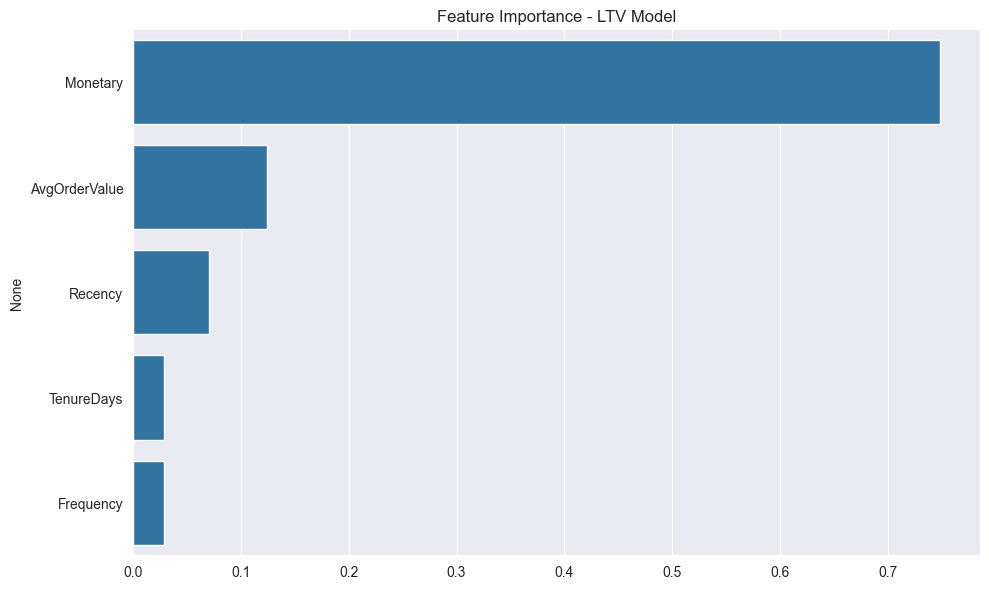

2026-02-21 18:16:40,307 - ltv_analysis - INFO - Saved customer_features_with_ltv.csv
2026-02-21 18:16:40,307 - ltv_analysis - INFO - Saved customer_features_with_ltv.csv


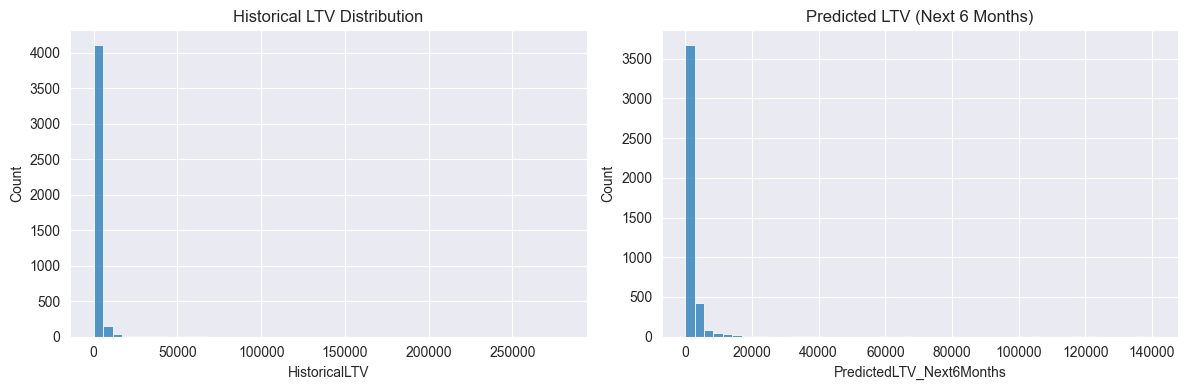

In [2]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.features.build_features import build_all_features
from src.models.churn_model import define_churn_labels, load_model
from src.models.ltv_model import (
    calculate_historical_ltv,
    prepare_ltv_features,
    train_predictive_ltv_model,
    save_ltv_model
)
from src.utils.logger import setup_logger

logger = setup_logger('ltv_analysis')

# Load data
df = pd.read_csv('../data/processed/cleaned_data.csv', parse_dates=['InvoiceDate'])
customer_features = pd.read_csv('../data/processed/customer_features.csv', index_col=0)

# 1. Historical LTV (all time)
ltv_historical = calculate_historical_ltv(df)
customer_features = customer_features.join(ltv_historical)
logger.info(f"Historical LTV stats:\n{customer_features['HistoricalLTV'].describe()}")

# 2. Predictive LTV: we need a target – e.g., LTV in next 12 months.
#    To create a target, we need to split data by time.
#    Use data up to a cutoff date to predict LTV after cutoff.

# Define cutoff date (e.g., 6 months before end)
cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(months=6)
logger.info(f"Cutoff date for training: {cutoff_date}")

# Transactions before cutoff (for features)
df_before = df[df['InvoiceDate'] <= cutoff_date]
# Transactions after cutoff (for target LTV)
df_after = df[df['InvoiceDate'] > cutoff_date]

# Build features using before-cutoff data (run feature engineering again)
customer_features_before = build_all_features(df_before)  # assumes function exists

# Compute target: LTV in after period per customer
ltv_target = df_after.groupby('CustomerID')['TotalPrice'].sum().rename('LTV_Next6Months')
customer_features_before = customer_features_before.join(ltv_target, how='left')
# Fill NaN only in the newly added LTV column
customer_features_before['LTV_Next6Months'] = customer_features_before['LTV_Next6Months'].fillna(0)

# Prepare features (excluding target)
feature_cols = ['Recency', 'Frequency', 'Monetary', 'TenureDays', 'AvgOrderValue']
X = customer_features_before[feature_cols].copy()
y = customer_features_before['LTV_Next6Months']

# Train predictive LTV model
model, X_train, X_test, y_train, y_test = train_predictive_ltv_model(X, y, model_type='random_forest')
save_ltv_model(model, '../models/ltv_model_rf.pkl')

# Feature importance
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Feature Importance - LTV Model')
    plt.tight_layout()
    plt.savefig('../reports/ltv_feature_importance.png')
    plt.show()

# Predict LTV for all customers (using full data or before-cutoff)
# For production, we'd use latest data to predict future LTV.
# Here we just demonstrate:
customer_features['PredictedLTV_Next6Months'] = model.predict(
    prepare_ltv_features(customer_features, include_churn=False)
)

# Save customer features with LTV columns
customer_features.to_csv('../data/processed/customer_features_with_ltv.csv')
logger.info("Saved customer_features_with_ltv.csv")

# Visualization: distribution of LTV
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(customer_features['HistoricalLTV'], bins=50, ax=axes[0])
axes[0].set_title('Historical LTV Distribution')
sns.histplot(customer_features['PredictedLTV_Next6Months'], bins=50, ax=axes[1])
axes[1].set_title('Predicted LTV (Next 6 Months)')
plt.tight_layout()
plt.savefig('../reports/ltv_distributions.png')
plt.show()